# Imports

In [ ]:
!pip install scikit-learn -q
!pip install transformers -q

In [1]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt


from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from transformers import Trainer, TrainingArguments


# Data


In [2]:
df_validation = pd.read_csv('https://raw.githubusercontent.com/EunjinAn/M4_Ex/main/data/validation.csv')
df_train = pd.read_csv('https://raw.githubusercontent.com/EunjinAn/M4_Ex/main/data/training.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/EunjinAn/M4_Ex/main/data/test.csv')

In [3]:
print('Dataset information:')
print(f'Training data: {df_train.shape}')
print(f'Validation data: {df_validation.shape}')
print(f'Test data: {df_test.shape}')


Dataset information:
Training data: (16000, 2)
Validation data: (2000, 2)
Test data: (2000, 2)


In [4]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [5]:
df_train['label'].unique()

array([0, 3, 2, 5, 4, 1])

In [6]:
id2label = { 0: "sadness", 
            1: "joy",
            2: "love",
            3: "anger",
            4: "fear",
            5: "surprise"
}

In [7]:
id2label[0]

'sadness'

In [8]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 10.2 MB/s eta 0:00:00


In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [12]:
tokenizer.tokenize('I am eating an apple.')

['i', 'am', 'eating', 'an', 'apple', '.']

In [13]:
tokenizer('I am eating an apple.')

{'input_ids': [101, 1045, 2572, 5983, 2019, 6207, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [14]:
tokenizer(["I am eating an apple.", "We like banana."], padding = True, truncation = True, max_length =512)

{'input_ids': [[101, 1045, 2572, 5983, 2019, 6207, 1012, 102], [101, 2057, 2066, 15212, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0]]}

In [15]:
tokenizer.decode([101, 1045, 2572, 5983, 2019, 6207, 1012, 102])

'[CLS] i am eating an apple. [SEP]'

In [16]:
X_train= df_train['text'].to_list()
y_train = df_train['label'].to_list()

In [17]:
X_train[0], y_train[0]


('i didnt feel humiliated', 0)

In [18]:
X_test = df_test['text'].to_list()
y_test = df_test['label'].to_list()

In [19]:
X_test[0], y_test[0]

('im feeling rather rotten so im not very ambitious right now', 0)

In [20]:
X_validation = df_validation['text'].to_list()
y_validation = df_validation['label'].to_list()

In [21]:
X_validation[0], y_validation[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [22]:
X_train_tokenize = tokenizer(X_train, padding = True, truncation = True, max_length =512)

In [23]:
X_validation_tokenize = tokenizer(X_validation, padding = True, truncation = True, max_length =512)

In [24]:
X_test_tokenize = tokenizer(X_test, padding = True, truncation = True, max_length =512)

# Model

In [25]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [26]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [28]:
class SentimentDataset(torch.utils.data.Dataset):
  def __init__(self, tokenizeData, labels= None):
    self.tokenizeData = tokenizeData
    self.labels = labels

  def __len__(self):
    return len(self.tokenizeData['input_ids'])

  def __getitem__(self, index):
    item = {'input_ids' : torch.tensor(self.tokenizeData['input_ids'][index]),
            'token_type_ids' : torch.tensor(self.tokenizeData['token_type_ids'][index]),
            'attention_mask' : torch.tensor(self.tokenizeData['attention_mask'][index])}
    if self.labels : 
      item['labels'] = torch.tensor(self.labels[index])

    return(item)



In [29]:
trainDataset = SentimentDataset(X_train_tokenize, y_train)

In [30]:
len(trainDataset)

16000

In [31]:
X_train_tokenize.keys()


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [32]:
trainDataset[0]

{'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0

In [33]:
validDataset = SentimentDataset(X_validation_tokenize, y_validation)

In [34]:
validDataset[0]

{'input_ids': tensor([  101, 10047,  3110,  3243,  6517,  1998,  3374,  2005,  2870,  2021,
          5665, 10245,  2041,  1997,  2009,  2574,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

# Train and validation


In [37]:
def compute(m):
  predictions, labels = m
  predictions = np.argmax(predictions, axis = 1)
  accuracy = accuracy_score(y_true = labels, y_pred = predictions)
  f1 = f1_score(y_true = labels, y_pred = predictions, average = 'macro')
  return({'accuracy': accuracy,
        'f1': f1})

In [38]:
targs= TrainingArguments(output_dir = 'output',
                         per_device_train_batch_size = 16,
                         per_device_eval_batch_size = 16, 
                         num_train_epochs = 3, 
                         save_strategy= 'epoch', 
                         evaluation_strategy ='epoch', 
                         seed = 42, 
                         optim="adamw_torch",
                         load_best_model_at_end = True)

In [39]:
trainer = Trainer(model = model, 
                  args = targs, 
                  train_dataset = trainDataset,
                  eval_dataset = validDataset,
                  compute_metrics= compute,
                  )

In [40]:
trainer.train()

***** Running training *****
  Num examples = 16000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3000
  Number of trainable parameters = 109486854


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.233800,0.190379,0.931500,0.907527
2,0.127000,0.156209,0.939000,0.913843
3,0.083800,0.219372,0.937000,0.914020


***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16
Saving model checkpoint to output/checkpoint-1000
Configuration saved in output/checkpoint-1000/config.json
Model weights saved in output/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16
Saving model checkpoint to output/checkpoint-2000
Configuration saved in output/checkpoint-2000/config.json
Model weights saved in output/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16
Saving model checkpoint to output/checkpoint-3000
Configuration saved in output/checkpoint-3000/config.json
Model weights saved in output/checkpoint-3000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output/checkpoint-2000 (score: 0.15620873868465424).


TrainOutput(global_step=3000, training_loss=0.20265013631184897, metrics={'train_runtime': 858.2438, 'train_samples_per_second': 55.928, 'train_steps_per_second': 3.496, 'total_flos': 2146076617536000.0, 'train_loss': 0.20265013631184897, 'epoch': 3.0})

# Test

In [41]:
testDataset = SentimentDataset(X_test_tokenize, y_test)

In [43]:
predictions, labels, results = trainer.predict(testDataset)
predictions = np.argmax(predictions, axis = 1)
results

***** Running Prediction *****
  Num examples = 2000
  Batch size = 16


{'test_loss': 0.15553343296051025,
 'test_accuracy': 0.935,
 'test_f1': 0.891896228559434,
 'test_runtime': 7.8335,
 'test_samples_per_second': 255.313,
 'test_steps_per_second': 15.957}

In [45]:
matrix = confusion_matrix(y_true = labels, y_pred = predictions)

In [46]:
matrix

array([[562,   5,   0,  10,   3,   1],
       [  0, 667,  19,   1,   1,   7],
       [  0,  31, 127,   1,   0,   0],
       [ 10,   2,   0, 256,   7,   0],
       [  5,   0,   0,   5, 213,   1],
       [  2,   0,   0,   1,  18,  45]])

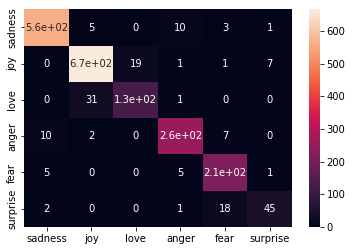

In [61]:
sns.heatmap(matrix, annot= True, xticklabels = id2label.values(), yticklabels = id2label.values())
plt.show()

In [57]:
id2label.values()

dict_values(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [62]:
def get_one_sentence(text):
    encoding = tokenizer(text, return_tensors="pt")
    outputs = model(**encoding.to("cuda"))
    prediction_ids = outputs.logits.argmax(-1)
    prediction_label = id2label[prediction_ids.item()]
    return prediction_label